In [1]:
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import random

In [2]:
%matplotlib inline

In [3]:
shape = (19,19)

# Implement game logic

In [4]:
class Gomoku:
    
    def __init__(self, shape):
        self.shape = shape
        self.reset()
        
    def reset(self):
        self.last_player = 1
        self.board = np.stack((np.zeros(self.shape), np.zeros(self.shape),np.ones(self.shape)), axis=2)
        self.previous_board = np.copy(self.board)
    
    def draw(self):
        plt.imshow(self.board)
    
    def list_actions(self):
        return np.transpose(np.nonzero(self.board[:,:,2])).tolist()
        
    def take_action(self, action):
        self.previous_board = np.copy(self.board)
        self.last_player = 1 - self.last_player 
        pixel = np.zeros((3))
        pixel[self.last_player] = 1
        self.board[action] = pixel
        self.last_action = action
        return self.__revard()
    
    def get_last_action(self):
        return self.last_action
    
    def get_state(self):
        return self.convert_state_for_player(self.board, self.last_player)
    
    def get_raw_state(self):
        return self.board
    
    def get_previous_state(self):
        return self.convert_state_for_player(self.previous_board, self.last_player)
    
    def convert_state_for_player(self, board, player):
        result = np.copy(board)
        
        if player == 1:
            tmp = np.copy(result[:,:,0])
            result[:,:,0] = result[:,:,1]
            result[:,:,1] = tmp
        
        return result

    def game_over(self):
        return self.__won(0) or self.__won(1) or np.count_nonzero(self.board[:,:,2]) == 0
    
    def __revard(self):
        return 1 if self.__won(self.last_player) else 0
        
    def __won(self, player):
        board = self.board[:,:, player]
        return (
            self.__has_five_by(np.identity(5), board) or 
            self.__has_five_by(np.fliplr(np.identity(5)), board) or 
            self.__has_five_by(np.ones((1,5)), board) or 
            self.__has_five_by(np.ones((5,1)), board)
        )
    
    def __has_five_by(self, mask, board):
        return np.count_nonzero(signal.convolve2d(mask, board) == 5) > 0
    
game = Gomoku(shape)        

# Deep Q learning

In [5]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

from IPython import display

Using TensorFlow backend.


In [6]:
hidden_layer_count = 40

In [7]:
input_state = Input(shape=game.get_state().shape)
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(input_state)
x = Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (5,5), padding='same', activation='relu')(x)
x = Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu', kernel_initializer='zeros', bias_initializer='zeros')(x)
x = BatchNormalization(axis=3)(x)
q_out = Conv2D(1, (3,3), padding='same')(x)
q_max = GlobalMaxPooling2D()(q_out)

model = Model(input_state, q_out)
training_model = Model(input_state, q_max)

opt = Nadam(lr=1e-5)
model.compile(optimizer=opt, loss='mean_squared_error')
training_model.compile(optimizer=opt, loss='mean_squared_error')

In [8]:
epsilon = 0.05

In [9]:
def make_move():
    if game.game_over():
        return
    
    if np.random.rand() < epsilon:
        action = tuple(random.choice(game.list_actions()))
    else: 
        q = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)
        action = tuple(sorted(game.list_actions(), key=lambda x: q[tuple(x)])[-1])
        
    revard = game.take_action(action)
    experiences.append([game.get_previous_state(), action, revard, game.get_state(), game.game_over()])

def make_manual_move(i, j):
    if game.game_over():
        return
    
    revard = game.take_action((i,j))
    experiences.append([game.get_previous_state(), (i,j), revard, game.get_state(), game.game_over()])

In [10]:
color_map = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)

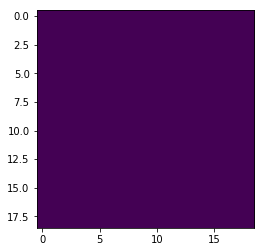

In [11]:
plt.imshow(color_map)

In [12]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def state_for_display():
    raw_state = game.get_raw_state()
    last_action = game.get_last_action()
    color_map = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)
    color_map = color_map - np.min(color_map)
    color_map = (color_map / np.max(color_map) * 255).astype(int)
    
    html = '<table>'
    for i in range(shape[0]):
        html += '<tr>'
        for j in range(shape[1]):
                        
            html += "<td style='border:1px solid gray; width:25px; height:25px; fotn-weight:bold; text-align:center; "
            if last_action == (i,j): 
                html += "background-color:rgb(255, "+str(color_map[i,j])+", "+str(255-color_map[i,j])+");" 
            else: 
                html += "background-color:rgb(0, "+ str(color_map[i,j]) +", "+str(255-color_map[i,j])+");" 
                
            html += "'"
            if raw_state[i,j,2]:
                html += " onclick='make_move("+str(i)+","+str(j)+")'"
            html += ">"
            if raw_state[i,j,0] == 1:
                html += 'X'
            if raw_state[i,j,1] == 1:
                html += 'O'
            if raw_state[i,j,0] == 1:
                html += '&nbsp;'                
                
            html += "</td>"
        html += '</tr>'

    html += '</table>'
    if game.game_over():
        html += '<h3>Game Over</h3>'
    print(html)

game.reset()



html = """

<div id='display_div'></div>
<button onclick='next()'>Make Next AI Move</button>
<button onclick='play()'>Autoplay</button>
<button onclick='reset()'>New Game</button>

<script type="text/Javascript">

    function display_state(out) {
        document.getElementById('display_div').innerHTML = out.content.text;
    }

    function next() {
        var kernel = IPython.notebook.kernel;
        kernel.execute('make_move()');
        kernel.execute('state_for_display()', {"iopub" : {"output":display_state}});
    }
    
    function make_move(i,j) {
        var kernel = IPython.notebook.kernel;
        kernel.execute('make_manual_move('+i+', '+j+')');
        kernel.execute('state_for_display()', {"iopub" : {"output":display_state}});
        setTimeout(next, 300);
    }
    
    function play() {
        var kernel = IPython.notebook.kernel;
        next();
        kernel.execute('print(game.game_over(), end="")', {"iopub" : {"output":function(out) {
            if(out.content.text == "False") {
                setTimeout(play, 100);
            }
        }}});
        
    }
    
    function reset() {
        var kernel = IPython.notebook.kernel;
        kernel.execute('game.reset()');
        next()
    }
    
    next()
</script>
"""

core_display(HTML(html))

# Loading real games

In [13]:
import os
from tqdm import tqdm

experiences = []

def letter_to_index(letter):
    if(ord(letter) < ord('J')):
        return ord(letter)-65
    else:
        return ord(letter)-66

def game_log_to_tuples(log):
    return list(map(lambda l: (letter_to_index(l[0]),int(l[1:-1])-1),log))

files = os.listdir('/data/bsd_gomoku_games')

skipped_files = 0

for filename in tqdm(files):
    with open('/data/bsd_gomoku_games/'+filename) as f:
        content = game_log_to_tuples(f.readlines())
    
    if len(content) < 200:
        game.reset()
        for move in content:
            make_manual_move(move[0],move[1])
    else:
        skipped_files += 1

print(skipped_files)

100%|██████████| 150/150 [00:44<00:00,  3.37it/s]

17


In [14]:
discount = 0.9

for k in tqdm(range(1000)):
    if k % 300:
        opt.lr = opt.lr/10
        
    seed_batch = random.sample(experiences, min(2000,len(experiences)))

    original_q = model.predict(np.array([item[0] for item in seed_batch]))
    new_q_max = training_model.predict(np.array([item[3] for item in seed_batch]))

    revards = np.array([item[2] for item in seed_batch])
    calculated_q = revards + discount * np.squeeze(new_q_max)

    loss = training_model.train_on_batch(np.array([item[0] for item in seed_batch]), calculated_q)
    
    display.clear_output(wait=True)
    print(loss)
    

100%|██████████| 1000/1000 [11:55<00:00,  1.40it/s]

0.0187006


# Training

In [ ]:
protect_until = len(experiences)

In [ ]:
protect_until

In [ ]:
epsilon = 0.05

In [ ]:
opt.lr = 1e-7

In [ ]:
discount = 0.9

In [ ]:
for i in tqdm(range(12000)):
    game.reset()
    game_length = 0
    while not game.game_over():
        if np.random.rand() < epsilon:
            action = tuple(random.choice(game.list_actions()))
        else: 
            q = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)
            action = tuple(sorted(game.list_actions(), key=lambda x: q[tuple(x)])[-1])

        revard = game.take_action(action)

        experiences.append([game.get_previous_state(), action, revard, game.get_state(), game.game_over()])
        game_length+=1

    experiences[-2][2] = -1
    
    for k in range(3):
        seed_batch = random.sample(experiences[:protect_until], min(1000,protect_until)) + random.sample(experiences[protect_until:], min(1000,len(experiences)-protect_until))

        original_q = model.predict(np.array([item[0] for item in seed_batch]))
        new_q_max = training_model.predict(np.array([item[3] for item in seed_batch]))

        revards = np.array([item[2] for item in seed_batch])
        calculated_q = revards + discount * np.squeeze(new_q_max)

        loss = training_model.train_on_batch(np.array([item[0] for item in seed_batch]), calculated_q)
    
    display.clear_output(wait=True)
    print(i, game_length, loss, '(', len(experiences), ')')
    
    if len(experiences) > 100000:
        experiences = experiences[:protect_until] + random.sample(experiences[protect_until:], 50000)
    